In [626]:
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA

import xgboost



from matplotlib import pyplot as plt
import seaborn as sns
import joblib

In [622]:
data=pd.read_excel('data/dataBiomass_CE880.xlsx',skiprows=2,header=0).drop('Number',axis=1)
# data=data[data['Superficial gas velocity']<8]

x=data.iloc[:,:8]
y=data.iloc[:,8:]

x=PCA(n_components=6).fit_transform(x)

mms_x=MinMaxScaler()
mms_y=MinMaxScaler()
x_norm=mms_x.fit_transform(x)
y_norm=mms_y.fit_transform(y)

x_train,x_test,y_train,y_test=train_test_split(x_norm,y_norm,test_size=0.2)
y_test_denorm=mms_y.inverse_transform(y_test)

In [ ]:
lr=LinearRegression()
lr.fit(x_train,y_train)
lr.predict()

In [623]:
dtr=DecisionTreeRegressor()
param_grid_dtr={
    'max_depth':[5,10,20,None],
    'min_samples_split':[2,5,10]
}
gs_dtr=GridSearchCV(dtr,param_grid_dtr,scoring='neg_mean_squared_error')
gs_dtr.fit(x_train,y_train)
best_rfr=gs_dtr.best_estimator_
y_pred=best_rfr.predict(x_test)
y_pred_denorm=mms_y.inverse_transform(y_pred)
rfr_rmse_score=mean_squared_error(y_test_denorm,y_pred_denorm,multioutput='raw_values',squared=False)
rfr_rmse_score_a=mean_squared_error(y_test_denorm,y_pred_denorm,multioutput='uniform_average',squared=False)
print(gs_dtr.best_estimator_.min_samples_split)
print(gs_dtr.best_params_)
print(rfr_rmse_score_a)
rfr_rmse_score

5
{'max_depth': None, 'min_samples_split': 5}
5.265568531031206


array([ 4.41687334,  5.04094885,  4.54545906,  2.10543573,  2.67835384,
        5.34482898, 12.72707992])

In [624]:
rfr=RandomForestRegressor()
param_grid_rfr={
    'n_estimators':[20,40,100],
    'max_depth':[5,20,40]
}
gs_rfr=GridSearchCV(rfr,param_grid=param_grid_rfr,scoring='neg_mean_squared_error',cv=6)
gs_rfr.fit(x_train,y_train)
# gs_rfr.best_score_
best_rfr=gs_rfr.best_estimator_
y_pred=best_rfr.predict(x_test)
y_pred_denorm=mms_y.inverse_transform(y_pred)
rfr_rmse_score=mean_squared_error(y_test_denorm,y_pred_denorm,multioutput='raw_values',squared=False)
rfr_rmse_score_a=mean_squared_error(y_test_denorm,y_pred_denorm,multioutput='uniform_average',squared=False)
print(gs_rfr.best_estimator_.min_samples_split)
print(gs_rfr.best_params_)
print(rfr_rmse_score_a)
rfr_rmse_score

2
{'max_depth': 40, 'n_estimators': 40}
4.301311989855703


array([ 3.49442953,  3.87371581,  4.05777312,  1.55987711,  1.79454014,
        4.81955869, 10.50928953])

In [625]:

params = {
    'max_depth': 40,
    'learning_rate': 0.2,
    'objective': 'reg:squarederror',  # 多分类问题
    'random_state':None
}
y_pred_total=[]
for i in range(7):
    train_DM=xgboost.DMatrix(data=x_train,label=y_train[:,i])
    test_DM=xgboost.DMatrix(data=x_test,label=y_test[:,i])
    bst=xgboost.train(params,train_DM,num_boost_round=200)
    y_pred=bst.predict(test_DM).reshape(-1,1)
    y_pred_total.append(y_pred)
y_pred=np.concatenate(y_pred_total,axis=1)
y_pred_denorm=mms_y.inverse_transform(y_pred)
xgb_rmse_score=mean_squared_error(y_test_denorm,y_pred_denorm,multioutput='raw_values',squared=False)
xgb_rmse_score_a=mean_squared_error(y_test_denorm,y_pred_denorm,multioutput='uniform_average',squared=False)

print(xgb_rmse_score_a)
xgb_rmse_score

4.415363199071689


array([ 3.59660524,  3.91501106,  3.95126007,  1.62795479,  2.37180563,
        4.79326953, 10.65163608])

In [537]:
rfr_1=RandomForestRegressor(n_estimators=40,max_depth=20)
rfr_1.fit(x_train,y_train)
y_pred=rfr_1.predict(x_test)
y_pred_denorm=mms_y.inverse_transform(y_pred)
rfr_rmse_score=mean_squared_error(y_test_denorm,y_pred_denorm,multioutput='raw_values',squared=False)
rfr_rmse_a=mean_squared_error(y_test_denorm,y_pred_denorm,multioutput='uniform_average',squared=False)
print(rfr_rmse_a)
rfr_rmse_score


4.2354641524524865


array([ 3.41811614,  4.0643452 ,  4.29357844,  1.55581566,  1.68385369,
        4.33217256, 10.30036738])

In [538]:
n_leaves_list=[]
for tree in rfr_1.estimators_:
    n_leaves_list.append(tree.get_n_leaves())
n_leaves_list

[158,
 161,
 158,
 164,
 160,
 155,
 165,
 158,
 162,
 169,
 156,
 159,
 165,
 170,
 169,
 168,
 165,
 159,
 158,
 159,
 157,
 159,
 158,
 162,
 162,
 160,
 163,
 157,
 158,
 153,
 161,
 173,
 168,
 157,
 167,
 158,
 162,
 157,
 155,
 155]

In [539]:
gs_rfr.best_params_

{'max_depth': 20, 'n_estimators': 100}

In [540]:
# svr=MultiOutputRegressor(SVR())
# param_grid_svr = {
#     'estimator__kernel': ['linear', 'rbf'],
#     'estimator__C': [0.1, 1.0, 10.0],
#     'estimator__epsilon': [0.1, 0.2, 0.5],
# }
# grid_svr=GridSearchCV(svr,param_grid=param_grid_svr,scoring='neg_mean_squared_error')
# grid_svr.fit(x_train,y_train)
# grid_svr.best_score_

In [541]:
# svr.get_params().keys()

In [542]:
best_rfr=gs_rfr.best_estimator_
y_pred=best_rfr.predict(x_test)

In [543]:
y_pred_denorm=mms_y.inverse_transform(y_pred)
rfr_rmse_score=mean_squared_error(y_test_denorm,y_pred_denorm,multioutput='raw_values',squared=False)
rfr_rmse_score

array([ 4.07695618,  4.16722574,  4.64394957,  1.59570116,  1.63760716,
        3.98877106, 10.60508441])

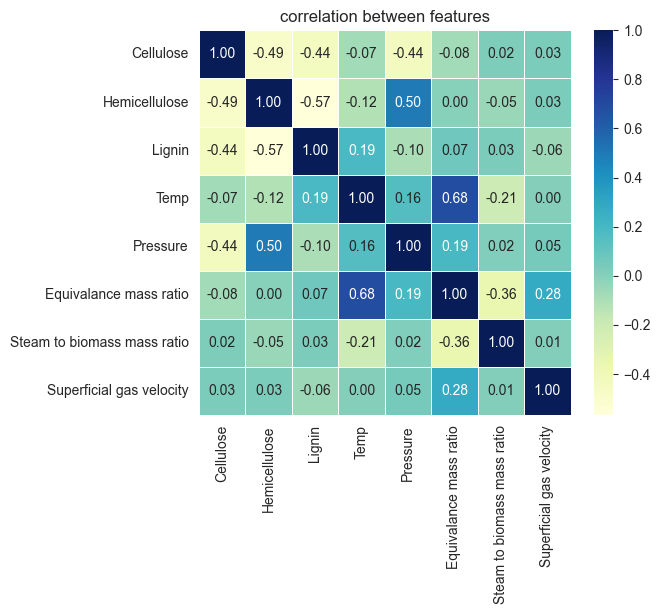

In [544]:
corr_matrix_feature=data.iloc[:,:8].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix_feature,cmap='YlGnBu',annot=True,linewidths=0.5,fmt='.2f')
plt.title('correlation between features')
plt.show()

In [545]:
# pca=PCA(n_components=4)
# x=pca.fit_transform(data.iloc[:,:8])
# y=data.iloc[:,8:]
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)


In [546]:
# dtr = DecisionTreeRegressor()
# param_grid_dtr = {
#     'max_depth': [5, 10, 20, None],
#     'min_samples_split': [2, 5, 10]
# }
# gs_dtr = GridSearchCV(dtr, param_grid_dtr, scoring='neg_mean_squared_error')
# gs_dtr.fit(x_train, y_train)
# gs_dtr.best_score_

In [547]:
# rfr = RandomForestRegressor()
# param_grid_rfr = {
#     'n_estimators': [5, 10, 20, 100],
#     'max_depth': [5, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }
# gs_rfr = GridSearchCV(rfr, param_grid=param_grid_rfr, scoring='neg_mean_squared_error')
# gs_rfr.fit(x_train, y_train)
# gs_rfr.best_score_

In [548]:
# best_rfr = gs_rfr.best_estimator_
# y_pred = best_rfr.predict(x_test)
# y_pred
# score_list = []
# arr_y_test = np.array(y_test)
# for i in range(y_test.shape[1]):
#     score_list.append(np.sqrt(mean_squared_error(arr_y_test[:, i], y_pred[:, i])))
# score_list


In [549]:
# pca.explained_variance_ratio_

In [550]:
import NeuralNetwork
from importlib import reload
reload(NeuralNetwork)
from NeuralNetwork import MLPBiomass,BiomassDataset


import torch
from torch.utils.data import DataLoader

from torch.nn import MSELoss
from torch.optim import Adam

In [551]:
data_train=np.concatenate([x_train,y_train],axis=1)
data_test=np.concatenate([x_test,y_test],axis=1)
tensor_data_train=torch.tensor(data_train,dtype=torch.float32)
tensor_data_test=torch.tensor(data_test,dtype=torch.float32)
nn_model=MLPBiomass(8,7)
dataset=BiomassDataset(tensor_data_train)

n_epochs=5555

batch_size=32
dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True,drop_last=False)

criterion=MSELoss()
optimizer=Adam(nn_model.parameters(),lr=0.0002)

for epoch in range(n_epochs):
    # training    
    nn_model.train()
    for batch,batch_data in enumerate(dataloader):
        optimizer.zero_grad()
        feat,label=batch_data[:,:8],batch_data[:,8:]
        pred=nn_model(feat)
        loss=criterion(pred,label)
        
        loss.backward()
        optimizer.step()
    
    # validation
    tensor_x_test=tensor_data_test[:,:8]
    tensor_y_test=tensor_data_test[:,8:]
    
    pred_test=nn_model.forward(tensor_x_test)
    pred_test_denorm=mms_y.inverse_transform(pred_test.detach().numpy())
    score_list=calculate_rmse(y_test_denorm,pred_test_denorm)
    
    if epoch%20==0:
        print(f'epoch:{epoch} - {score_list}')

NameError: name 'calculate_rmse' is not defined

In [ ]:
rfr_rmse_score